In [1]:
import os
import glob
from PIL import Image
import re
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import cv2
import torch.nn.functional as F



In [2]:


def create_image_depth_dict(image_dir, depth_dir, depth_scale=256.0):
    """
    Creates a dictionary where each key is an image file name, 
    and each value is a dictionary with 'image_path' and 'depth_map' (in meters).

    Args:
        image_dir (str): Directory containing the images.
        depth_dir (str): Directory containing the depth maps.
        depth_scale (float): Scale factor for depth conversion (256 for KITTI).

    Returns:
        dict: A dictionary with image file names as keys and values containing 
              'image_path' and 'depth_map' as depth in meters.
    """
    image_depth_dict = {}

    # Find all image files in the image directory
    image_files =  glob.glob(f"{image_dir}/*")
    for image_path in image_files:
        # Extract the unique identifier for matching the depth file
        identifier1 = re.sub(r'_sync_image.*', '_sync_groundtruth_depth_', os.path.basename(image_path))
        identifier2= os.path.basename(image_path).split("image_00")[-1]

        depth_path = '/media/aditya/ExtraSpace/3D_Object_Detection/Dataset/ground_truth/' + identifier1 + '00' + identifier2
        # break
        # Construct the depth file path based on the identifier
        
        
        # Check if the corresponding depth file exists
        if not os.path.exists(depth_path):
            print(f"Depth file not found for image {image_path}")
            continue
        
        # Load and convert the depth map to real-world depth values in meters
        depth = Image.open(depth_path)
        depth = np.array(depth).astype(np.float32) / depth_scale  # Convert to meters
        
        # Store in dictionary using the identifier as the key
        image_depth_dict[image_path] = {

            'depth_map': depth
        }

    return image_depth_dict

# Example usage
image_dir = '/media/aditya/ExtraSpace/3D_Object_Detection/Dataset/image'
depth_dir = '/media/aditya/ExtraSpace/3D_Object_Detection/Dataset/ground_truth'

image_depth_dict = create_image_depth_dict(image_dir, depth_dir)
print(f"Processed {len(image_depth_dict)} images with corresponding depth maps.")


Processed 500 images with corresponding depth maps.


(1216, 352)


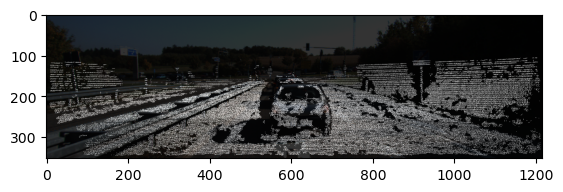

In [3]:
def overlay_depth_on_image_from_dict(data_dict, key, alpha=0.6):
    """
    Overlays a depth map on an image from a dictionary entry.

    Args:
        data_dict (dict): Dictionary where each key is an image identifier, 
                          and each value is a dictionary with 'image_path' and 'depth_map'.
        key (str): The key for the desired image and depth map in the dictionary.
        alpha (float): Transparency factor for the depth overlay (0=fully transparent, 1=fully opaque).

    Returns:
        PIL.Image: The resulting image with depth overlay.
    """
    # Retrieve the image path and depth map from the dictionary
    depth_map = data_dict[key]['depth_map']
    
    # Load the image
    image = Image.open(key).convert("RGB")
    
    # Normalize depth map to range 0-255 for visualization
    depth_normalized = 255 * (depth_map - np.min(depth_map)) / (np.max(depth_map) - np.min(depth_map))
    depth_normalized = 1-depth_normalized.astype(np.uint8)
    
    # Convert depth to RGB for overlaying
    depth_colored = Image.fromarray(depth_normalized).convert("RGB")

    # Resize depth map to match image size if necessary
    if depth_colored.size != image.size:
        depth_colored = depth_colored.resize(image.size, Image.BILINEAR)

    # Combine image and depth map with transparency
    overlayed_image = Image.blend(image, depth_colored, alpha)

    return overlayed_image

# Example usage
# Assuming your dictionary is called `image_depth_dict`
key = '/media/aditya/ExtraSpace/3D_Object_Detection/Dataset/image/2011_10_03_drive_0047_sync_image_0000000785_image_02.png'  # Replace with a valid key from your dictionary

overlayed_image = overlay_depth_on_image_from_dict(image_depth_dict, key, alpha=0.8)
print(overlayed_image.size)
# Display the result
plt.imshow(overlayed_image)
# plt.axis("off")
plt.show()


In [4]:
depth_map=image_depth_dict[key]['depth_map']
depth_map.shape

(352, 1216)

In [5]:
model_type = "DPT_Hybrid"  # Choose model type as per requirements
midas = torch.hub.load("intel-isl/MiDaS", model_type)
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")


Using cache found in /home/aditya/.cache/torch/hub/intel-isl_MiDaS_master
/home/aditya/anaconda3/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/aditya/anaconda3/lib/python3.12/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name vit_base_resnet50_384 to current vit_base_r50_s16_384.orig_in21k_ft_in1k.
  model = create_fn(
Using cache found in /home/aditya/.cache/torch/hub/intel-isl_MiDaS_master


In [6]:
# Set the appropriate transform for the chosen model type
if model_type in ["DPT_Large", "DPT_Hybrid"]:
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

In [7]:
from sklearn.model_selection import train_test_split

# Split the keys into training and testing sets (80% train, 20% test in this example)
image_paths = list(image_depth_dict.keys())
train_paths, test_paths = train_test_split(image_paths, test_size=0.2, random_state=42)

# Create separate dictionaries for train and test sets
train_image_depth_dict = {path: image_depth_dict[path] for path in train_paths}
test_image_depth_dict = {path: image_depth_dict[path] for path in test_paths}




In [8]:
class KITTI_Dataset(Dataset):
    def __init__(self, data_dict):
        self.data_dict = data_dict
        self.image_paths = list(data_dict.keys())
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        
        img_path = self.image_paths[idx]
        
        image = Image.open(img_path).convert("RGB")
        ground_truth_depth = self.data_dict[img_path]['depth_map']
        image=transform(np.array(image))
        # # Preprocessing (resize, normalize, etc.)
        
        ground_truth_depth = torch.tensor(ground_truth_depth).float()
        ground_truth_depth=ground_truth_depth.reshape(ground_truth_depth.shape[1],ground_truth_depth.shape[0])
        return image, ground_truth_depth

# Initialize datasets and dataloaders
train_dataset = KITTI_Dataset(train_image_depth_dict)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

test_dataset = KITTI_Dataset(test_image_depth_dict)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [9]:
images, outputs = next(iter(train_loader))
print("Batch of images shape:", images.shape)  # Should be (batch_size, 3, 224, 224)
print("Batch of lane points shape:", outputs.shape)  # Should be (batch_size, 48)

# Inspect the first image and its corresponding points in the batch
first_image = images[0]
first_points = outputs[0]

print("First image shape:", first_image.shape)  # Should be (3, 224, 224)
print("First lane points:", first_points.shape)


Batch of images shape: torch.Size([1, 1, 3, 384, 1312])
Batch of lane points shape: torch.Size([1, 1216, 352])
First image shape: torch.Size([1, 3, 384, 1312])
First lane points: torch.Size([1216, 352])


In [10]:
for param in midas.parameters():
    param.requires_grad = False

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AbsoluteDepthModel(nn.Module):
    def __init__(self, midas_model):
        super(AbsoluteDepthModel, self).__init__()
        self.midas_model = midas_model
        
        # 1x1 Convolution layers to learn pixel-wise transformations
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=1),  # Input channels = 1 (depth map)
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=1) # Output channels = 1 (absolute depth)
        )
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # Step 1: Get relative inverse depth prediction from MiDas
        relative_depth = self.midas_model(x)  # Shape: (batch, 1, H, W)
        
        
        
        # Step 3: Resize depth map to desired dimensions
        resized_depth = F.interpolate(
            relative_depth.unsqueeze(1),  # Add channel dimension
            size=(352, 1216),
            mode="bicubic",
            align_corners=False
        )
        
        # Step 4: Apply 1x1 convolution for pixel-wise transformation
        absolute_depth = self.conv(resized_depth)
        absolute_depth = self.relu(absolute_depth)  # Ensure non-negative depth
        
        return absolute_depth.squeeze(1)  # Shape: (batch, H, W)


In [12]:
model = AbsoluteDepthModel(midas)


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())
model = model.to(device)

True


In [14]:
# Use MSE loss for regression
criterion = nn.MSELoss() 
# Optimizer (you can adjust learning rate as needed)
optimizer = optim.AdamW(model.parameters(), lr=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=10)


In [15]:
# print(device)
num_epochs = 40  # You can change this depending on your needs

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    
    # Training loop
    for images, points in train_loader:
  
        images = images.to(device)
        points = points.to(device)

        optimizer.zero_grad()
        
        points=points.permute(0,2,1)
        images=images.squeeze(0)
        
        non_zero_indices = torch.nonzero(points, as_tuple=True)

        # Select non-zero elements from both points and outputs
        
        # print(f" Scale Factor: {model.scale_factor.item():.4f} Offset :{model.offset.item():.4f}")
        outputs = model(images)

        points_non_zero = points[non_zero_indices]
        outputs_non_zero = outputs[non_zero_indices]
        loss = criterion(outputs_non_zero, points_non_zero)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # scheduler.step()
    
    # Testing loop
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    
    with torch.no_grad():  # No need to track gradients for testing
        for images, points in test_loader:
            images = images.to(device)
            points = points.to(device)
            points=points.permute(0,2,1)
            images=images.squeeze(0)
            
            non_zero_indices = torch.nonzero(points, as_tuple=True)
            # Forward pass
            outputs = model(images)
            
            # Compute the loss (no backward pass for testing)
            points_non_zero = points[non_zero_indices]
            outputs_non_zero = outputs[non_zero_indices]
            
            loss = criterion(outputs_non_zero, points_non_zero)
            
            # Accumulate test loss
            test_loss += loss.item()
    
    # Print statistics for testing
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {running_loss/len(train_loader):.4f} , Test Loss: {test_loss/len(test_loader):.4f}")


KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), 'best_depth_model.pth')

In [17]:
state_dict = torch.load('depth.pth', weights_only=True)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [18]:
test_image_path='/media/aditya/ExtraSpace/3D_Object_Detection/Dataset/image/2011_09_26_drive_0002_sync_image_0000000017_image_02.png'
test_image=Image.open(test_image_path)
image_in=transform(np.array(test_image))
image_in.shape

torch.Size([1, 3, 384, 1312])

In [19]:
model.eval()
with torch.no_grad():
    image_in=image_in.to(device)
    output=model(image_in)
    output = torch.nn.functional.interpolate(
        output.unsqueeze(1),
        size=np.array(test_image).shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

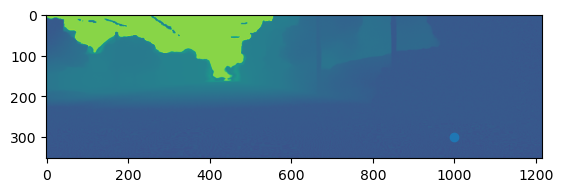

In [33]:
predictions=output.cpu().numpy()
predictions=predictions.reshape((352,1216))
plt.imshow(predictions,cmap='viridis',vmax=np.max(predictions),vmin=10.0)
plt.scatter(1000,300)

In [30]:
ground_truth_depth=(image_depth_dict[test_image_path]['depth_map'])
print(ground_truth_depth[12,400])
print(predictions[0,400])

0.0
23.80252


In [22]:
np.unique(predictions)

array([13.460186, 13.487606, 13.495502, ..., 26.757923, 26.758957,
       26.76003 ], dtype=float32)

In [23]:
print(np.max(predictions))
print(np.max(image_depth_dict[test_image_path]['depth_map']))

26.76003
80.52734


In [ ]:
print(np.column_stack((np.where(ground_truth_depth[:,:]>0)[0],np.where(ground_truth_depth[:,:]>0)[1])))


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 90 and the array at index 1 has size 110931

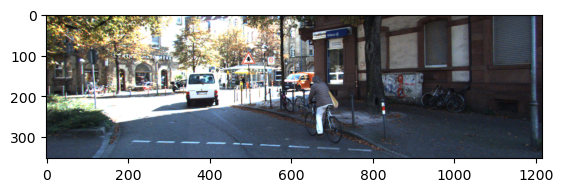

In [ ]:
plt.imshow(test_image)

In [ ]:
midas.eval()
input_batch = transform(np.array(test_image)).to(device)
with torch.no_grad():
    prediction = midas(input_batch)

    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=np.array(test_image).shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

output = prediction.cpu().numpy()*s+t

NameError: name 's' is not defined

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

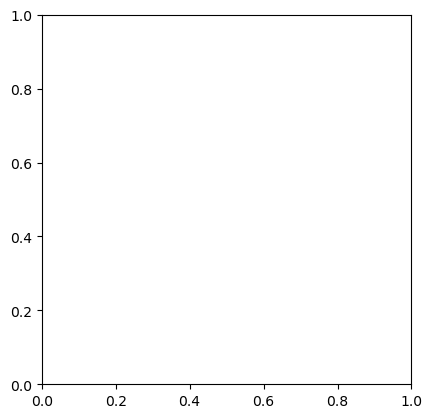

In [ ]:
plt.imshow(output)

In [ ]:
D_r = output.flatten()  # Flattened relative depth (predicted by MiDaS)
D_a_gt = ground_truth_depth.flatten()  # Flattened ground truth absolute depth

# Create a mask to exclude zero values in ground truth
mask = D_a_gt > 0  # Keep only non-zero ground truth values

# Mask the relative depth and ground truth arrays
D_r_masked = D_r[mask]
D_a_gt_masked = D_a_gt[mask]

# Construct matrix A for the least squares problem
# A = [D_r, 1], where the first column is D_r and the second column is all ones
A = np.vstack([D_r_masked, np.ones_like(D_r_masked)]).T

# Solve for s and t using least squares
# lstsq solves Ax = b, where x contains [s, t]
x, residuals, rank, s = np.linalg.lstsq(A, D_a_gt_masked, rcond=None)

# Extract scaling factor (s) and shift (t)
s, t = x

# Output the results
print(f"Scaling factor (s): {s}")
print(f"Shift (t): {t}")

# Apply the transformation to get absolute depth
D_a = s * D_r + t
# D_a.reshape((ground_truth_depth[0],ground_truth_depth[1]))

Scaling factor (s): -0.11582999676465988
Shift (t): 33.22417449951172


In [ ]:
output=output*s+t

In [ ]:
ground_truth_depth[200,653]

7.6875

In [ ]:
output[200,653]

153.19557

In [ ]:
output.shape

(352, 1216)

In [ ]:
np.max(output)

4.0513587

In [ ]:
output

array([[ 0.60788417,  0.5983534 ,  0.59576416, ...,  1.5512156 ,
         1.544476  ,  1.591228  ],
       [ 0.6043236 ,  0.5980022 ,  0.5950613 , ...,  1.5325785 ,
         1.5391655 ,  1.5419233 ],
       [ 0.60364056,  0.5925193 ,  0.60393   , ...,  1.532646  ,
         1.5297742 ,  1.5392501 ],
       ...,
       [-0.15647984, -0.17023516, -0.16417742, ..., -0.38980675,
        -0.38771582, -0.39622164],
       [-0.18538904, -0.18964767, -0.18681145, ..., -0.4008727 ,
        -0.40074492, -0.40707493],
       [-0.19565678, -0.19972086, -0.20312452, ..., -0.41958618,
        -0.41933393, -0.41645575]], dtype=float32)